In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, LabelEncoder
import keras
from keras.models import Sequential, load_model
from keras.layers import InputLayer, Dense, Activation, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, MaxPooling1D, Conv1D, GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.regularizers import l1_l2
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.utils import to_categorical
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.constraints import max_norm, min_max_norm
# from wordcloud import WordCloud
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer

from gensim.models.fasttext import FastText as FT_gensim

import sys
import requests
import re

import gc
from time import time

import csv
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Класс для препроцессинга рускоязычного текста: удаление стоп-слов и пунктуации, далее стемминг(Snowball)

In [0]:
class NLTKPreprocessor_russian(BaseEstimator, TransformerMixin):
    
    def __init__(self, stopword=True, lower=True, punkt=True):
        self.stopwords = set(stopwords.words('russian')) if stopword else False
        self.punct = set(string.punctuation)
        self.stemmer = SnowballStemmer('russian')
        self.lower = lower
        self.punkt = punkt
        
    def fit(self, X, y=None):
        return self
    
    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X, only_tokenize=False):
        return [list(self.tokenize(doc, only_tokenize=only_tokenize)) for doc in X]
    
    def tokenize(self, document, only_tokenize):
        for token in word_tokenize(document):
            if self.lower:
                token = token.lower()
            if self.stopwords:
                if (token in self.stopwords):
                    continue 
            if self.punkt:
                if all([char in self.punct for char in token]):
                    continue
            if only_tokenize:
                yield token
            else:
                yield self.stemmer.stem(token)

Загружаем отзывы и сразу удаляем пропущенные значения:

In [0]:
df = pd.read_csv('./data/feedback.csv', quoting=csv.QUOTE_NONE).dropna()
df.head()

,rating,product_id,name,date,feedback
0,1.0,8342,Александр,2017-04-12,6 входов предохранитель искрит при включен...
1,5.0,8342,Елена,2015-08-04,Я являюсь пользователем Пилотов уже больше 10...
2,5.0,5311,Леонид,2017-07-16,хорошо мелет маркий остаются следы Испол...
3,4.0,5311,Сергей,2017-06-28,Компактная Не нашел Работает на ура. В инст...
4,5.0,5311,Ольга,2017-01-21,Цена и качество Нет В использовании 2 месяц...


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17505 entries, 0 to 18341
Data columns (total 5 columns):
rating        17505 non-null float64
product_id    17505 non-null int64
name          17505 non-null object
date          17505 non-null object
feedback      17505 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 820.5+ KB


Округляем рейтинг, чтобы решать задачу классификации для 5 классов:

In [0]:
df['rating'] = df['rating'].apply(np.around)

Классы не сбалансированны, больше отзывов с рейтингом 5

5.0    10389
4.0     3048
1.0     1630
3.0     1457
2.0      981
Name: rating, dtype: int64

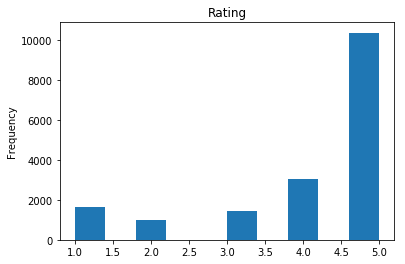

In [0]:
df['rating'].plot(kind='hist', title='Rating');
df['rating'].value_counts()

Препроцессинг отзывов: токенизация, удаление стоп слов и пунктуации, стемминг

In [0]:
preprocessor = NLTKPreprocessor_russian()
df['tokens_stemm'] = preprocessor.transform(df['feedback'])
df['len_stemm_tokens'] = df['tokens_stemm'].apply(lambda x: len(x))

In [0]:
df.head()

,rating,product_id,name,date,feedback,tokens_stemm,len_stemm_tokens
0,1.0,8342,Александр,2017-04-12,6 входов предохранитель искрит при включен...,"[6, вход, предохранител, искр, включен, люб, у...",24
1,5.0,8342,Елена,2015-08-04,Я являюсь пользователем Пилотов уже больше 10...,"[явля, пользовател, пилот, 10, лет, каких-либ,...",69
2,5.0,5311,Леонид,2017-07-16,хорошо мелет маркий остаются следы Испол...,"[мелет, марк, оста, след, использ, 1, месяц, п...",9
3,4.0,5311,Сергей,2017-06-28,Компактная Не нашел Работает на ура. В инст...,"[компактн, нашел, работа, ур, инструкц, четк, ...",33
4,5.0,5311,Ольга,2017-01-21,Цена и качество Нет В использовании 2 месяц...,"[цен, качеств, использован, 2, месяц, перемалы...",10


### EDA:

Распределение длинн отзывов: видим что большая часть отзывов не больше 100 слов

Max length for stemm_tokens: 390


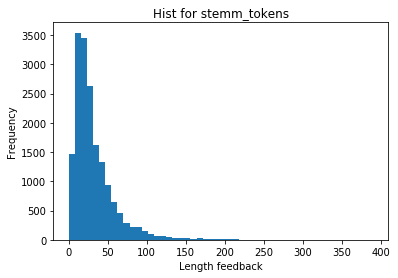

In [0]:
df['len_stemm_tokens'].plot(kind='hist', bins=50, title='Hist for stemm_tokens');
plt.xlabel('Length feedback');
print('Max length for stemm_tokens: {}'.format(df['len_stemm_tokens'].max()))

In [0]:
df.head()

,rating,product_id,name,date,feedback,only_tokens,num_!,num_(,num_),num_CAPS
0,1.0,8342,Александр,2017-04-12,6 входов предохранитель искрит при включен...,"[6, входов, предохранитель, искрит, включении,...",0,0,0,0
1,5.0,8342,Елена,2015-08-04,Я являюсь пользователем Пилотов уже больше 10...,"[являюсь, пользователем, пилотов, 10, лет, как...",0,0,0,0
2,5.0,5311,Леонид,2017-07-16,хорошо мелет маркий остаются следы Испол...,"[мелет, маркий, остаются, следы, использую, 1,...",0,0,0,0
3,4.0,5311,Сергей,2017-06-28,Компактная Не нашел Работает на ура. В инст...,"[компактная, нашел, работает, ура, инструкции,...",0,0,0,0
4,5.0,5311,Ольга,2017-01-21,Цена и качество Нет В использовании 2 месяц...,"[цена, качество, использовании, 2, месяца, пер...",0,0,0,0


Добавил несколько фич которые могли бы отражать эмоциональную окраску отзывов(число !, ), (, слова написанные капсом):

In [0]:
df['num_!'] = df['feedback'].apply(lambda x: x.count('!'))
df['num_('] = df['feedback'].apply(lambda x: x.count('('))
df['num_)'] = df['feedback'].apply(lambda x: x.count(')'))
df['num_CAPS'] = df['feedback'].apply(lambda x: len(re.findall(r'[А-Я][А-Я]+', x)))

Но особо различий для групп нет: разве что для восклицательных знаков, у 1 и 5 группы их число чуть больше чем у остальных.

In [0]:
df.groupby(['rating'])['num_!', 'num_(', 'num_)', 'num_CAPS'].mean()

,num_!,num_(,num_),num_CAPS
rating,,,,
1.0,1.130061,0.374233,0.415337,0.244785
2.0,0.787971,0.402650,0.478084,0.209990
3.0,0.719973,0.539465,0.568291,0.209334
4.0,0.657152,0.578740,0.811352,0.294619
5.0,1.373183,0.362884,0.779960,0.203292


WordCloud для групп, с предварительным удалением стопслов. Видно что 1, 2, мало отличаются, 5 впринципе больше всех отличается по самым частым словам.

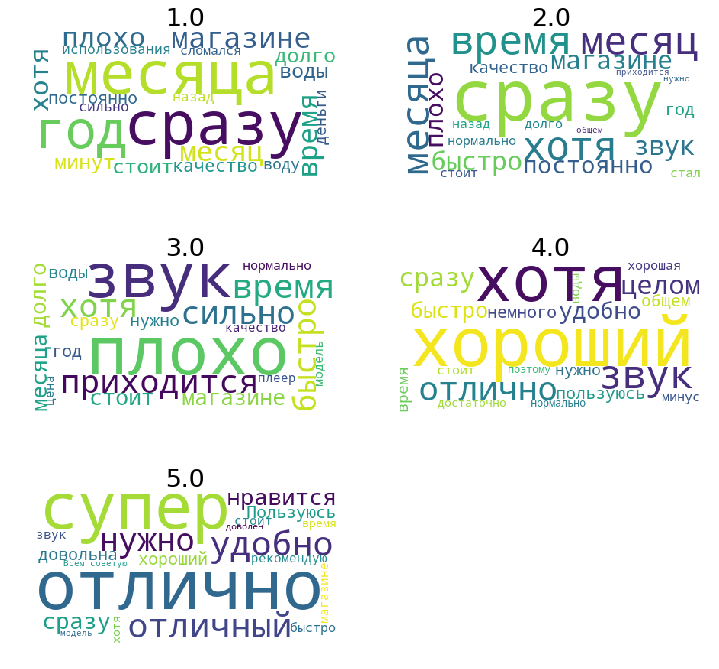

In [0]:
my_stopwords = stopwords.words('russian')
my_stopwords.extend(['это', 'очень', 'просто', 'работает', 'купил', 'купила',
                     'купили', 'вообще', 'года', 'чайник', 'пылесос', 'телефон', 'всё', 'пока'])

fig, ax = plt.subplots(3,2)
fig.set_size_inches(12, 12)
gr = df.groupby('rating')['feedback']
i = 0
for group, texts in gr:
    cloud = WordCloud(background_color='white', stopwords=my_stopwords, max_words=20).generate(' '.join(texts))
    ax[i // 2][i % 2].imshow(cloud)
    ax[i // 2][i % 2].axis('off')
    ax[i // 2][i % 2].set_title(group, fontsize=25)
    i+=1
fig.delaxes(ax[2][1])

Визуализация групп с помощью tSNE: для этого была взята предобученная на рускоязычной wiki w2v модель(см. пункт 3) ниже и для каждого отзыва были проссумированны вектора его токенов после лемматизации

In [0]:
def w2v_for_doc(doc, w2v_model):
    doc2vec = np.zeros((300,))
    for token in doc:
        if token not in w2v_model.wv.vocab:
            continue
        doc2vec += w2v_model[token]
    return doc2vec

In [0]:
df['w2v_sum'] = df['feedback_lemm_tags'].apply(lambda x: w2v_for_doc(x, model))

In [0]:
tsne = TSNE(random_state=42)
df_tsne_1 = df['w2v_sum'].apply(pd.Series)
tsne_representation_1 = tsne.fit_transform(df_tsne_1)

Каких то намеков на разделение групп почти нет:

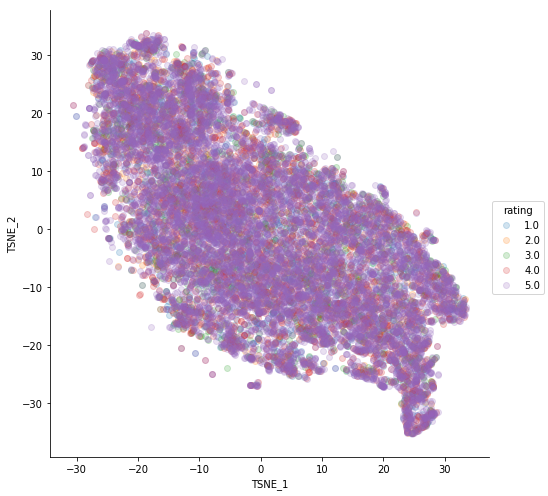

In [0]:
df_tsne_1 = pd.DataFrame(tsne_representation_1, columns=['TSNE_1', 'TSNE_2'])
df_tsne_1['rating'] = df.rating
sns.lmplot('TSNE_1', 'TSNE_2', data=df_tsne_1, fit_reg=False, hue='rating', scatter_kws={'alpha':0.2}, size=7);

### 1. Обучить рекуррентную нейронную сеть для предсказания оценки пользователя по его отзыву для русскоязычного текста. Использовать случайную инициализация весов. 

Передобработка для keras:  
возьмем 20000 самых частых слов и унифицируем длину последовательности(100 слов)

In [0]:
max_features = 20000
maxlen = 100

tk = Tokenizer(num_words=max_features)
tk.fit_on_texts(df['tokens_stemm'])
X_stemm = sequence.pad_sequences(tk.texts_to_sequences(df['tokens_stemm']), maxlen=maxlen)

In [0]:
y = df['rating'].values
y_binary = pd.get_dummies(y)

In [0]:
stemm_X_train, stemm_X_test, stemm_y_train, stemm_y_test = train_test_split(X_stemm, y_binary, 
                                                                            test_size=0.2, random_state=42)
stemm_X_train, stemm_X_val, stemm_y_train, stemm_y_val = train_test_split(stemm_X_train, stemm_y_train, 
                                                                            test_size=0.1, random_state=42)

Модель: слой эмбеддинга и двунаправленный LSTM

In [0]:
def get_baseline_model():
    baseline_model = Sequential()
    baseline_model.add(Embedding(max_features, 64))
    baseline_model.add(Bidirectional(LSTM(64)))
    baseline_model.add(Dense(5, activation='softmax'))
    baseline_model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return baseline_model

In [0]:
batch_size=32
epochs = 100

baseline_model = get_baseline_model()
# checkpoint
filepath='./models/task2_baseline.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_entropy', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=2, verbose=0, mode='max')

print('Train baseline model...')
baseline_model.fit(stemm_X_train, stemm_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[stemm_X_val, stemm_y_val])

Train baseline model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 47s 4ms/step - loss: 1.0258 - categorical_accuracy: 0.6237 - val_loss: 0.8906 - val_categorical_accuracy: 0.6467
Epoch 2/100
12603/12603 [==============================] - 47s 4ms/step - loss: 0.7701 - categorical_accuracy: 0.6921 - val_loss: 0.8544 - val_categorical_accuracy: 0.6817
Epoch 3/100
12603/12603 [==============================] - 48s 4ms/step - loss: 0.6224 - categorical_accuracy: 0.7507 - val_loss: 0.9448 - val_categorical_accuracy: 0.6660
Epoch 4/100
12603/12603 [==============================] - 44s 4ms/step - loss: 0.5135 - categorical_accuracy: 0.8081 - val_loss: 1.0405 - val_categorical_accuracy: 0.6474


In [0]:
batch_size=32
epochs = 100

baseline_model = get_baseline_model()
# checkpoint
filepath='./models/task2_baseline.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_entropy', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=2, verbose=0, mode='max')

print('Train baseline model...')
baseline_model.fit(stemm_X_train, stemm_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[stemm_X_val, stemm_y_val])

Train baseline model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 46s 4ms/step - loss: 1.0292 - categorical_accuracy: 0.6183 - val_loss: 0.8996 - val_categorical_accuracy: 0.6531
Epoch 2/100
12603/12603 [==============================] - 46s 4ms/step - loss: 0.7730 - categorical_accuracy: 0.6916 - val_loss: 0.8773 - val_categorical_accuracy: 0.6788
Epoch 3/100
12603/12603 [==============================] - 44s 3ms/step - loss: 0.6042 - categorical_accuracy: 0.7653 - val_loss: 0.9621 - val_categorical_accuracy: 0.6674
Epoch 4/100
12603/12603 [==============================] - 44s 4ms/step - loss: 0.4633 - categorical_accuracy: 0.8221 - val_loss: 1.0819 - val_categorical_accuracy: 0.6510


In [0]:
baseline_model = load_model('./models/task2_baseline.hdf5')
results = baseline_model.evaluate(stemm_X_test, stemm_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results[0], results[1]))

3501/3501 [==============================] - 4s 1ms/step
Categorical_entropy for test: 0.8838360121133702
Categorical_accuracy for test: 0.6560982577087743


In [0]:
# baseline_model = load_model('./models/task2_baseline.hdf5')
results = baseline_model.evaluate(stemm_X_test, stemm_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results[0], results[1]))

3501/3501 [==============================] - 2s 673us/step
Categorical_entropy for test: 1.0686524790104919
Categorical_accuracy for test: 0.6303913168347383


In [0]:
baseline_test_roc_auc = baseline_model.predict(stemm_X_test)
baseline_result = roc_auc_score(stemm_y_test, baseline_test_roc_auc, average='micro')
print('ROC AUC for test (baseline): {}'.format(baseline_result))

ROC AUC for test (baseline): 0.8875651556200412


### 2. Обучить«fasttext» модель на n-граммах используя случайную инициализацию эмбедингов.

Функции для добавления n-gram:

In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
# Set parameters:
ngram_range = 2 
max_features = 20000
maxlen = 100

In [0]:
tk.fit_on_texts(df['tokens_stemm'])
X_stemm = tk.texts_to_sequences(df['tokens_stemm'])

In [0]:
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in X_stemm:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    X_stemm = add_ngram(X_stemm, token_indice, ngram_range)

print('Pad sequences')
X_stemm = sequence.pad_sequences(X_stemm, maxlen=maxlen)

Adding 2-gram features
Pad sequences


In [0]:
stemm_X_train, stemm_X_test, stemm_y_train, stemm_y_test = train_test_split(X_stemm, y_binary, 
                                                                            test_size=0.2, random_state=42)
stemm_X_train, stemm_X_val, stemm_y_train, stemm_y_val = train_test_split(stemm_X_train, stemm_y_train, 
                                                                            test_size=0.1, random_state=42)

Модель: теперь только эмбеддинги и GlobalAveragePooling

In [0]:
def get_GAP_model():
    model = Sequential()
    model.add(Embedding(max_features,64))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
batch_size = 32
epochs = 100

glp_model = get_GLP_model()

# checkpoint
filepath='./models/task2_GLP_2_gram.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', 
                             verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=2, verbose=0, mode='max')

print('Train GLP_2_gram model...')
glp_model.fit(stemm_X_train, stemm_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[stemm_X_val, stemm_y_val])

Train GLP_2_gram model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 129s 10ms/step - loss: 1.2634 - categorical_accuracy: 0.5895 - val_loss: 1.1717 - val_categorical_accuracy: 0.5789
Epoch 2/100
12603/12603 [==============================] - 132s 10ms/step - loss: 1.0494 - categorical_accuracy: 0.5968 - val_loss: 1.0532 - val_categorical_accuracy: 0.5782
Epoch 3/100
12603/12603 [==============================] - 129s 10ms/step - loss: 0.8435 - categorical_accuracy: 0.6652 - val_loss: 0.9513 - val_categorical_accuracy: 0.6174
Epoch 4/100
12603/12603 [==============================] - 131s 10ms/step - loss: 0.6520 - categorical_accuracy: 0.7702 - val_loss: 0.8897 - val_categorical_accuracy: 0.6502
Epoch 5/100
12603/12603 [==============================] - 132s 10ms/step - loss: 0.4982 - categorical_accuracy: 0.8472 - val_loss: 0.8557 - val_categorical_accuracy: 0.6695
Epoch 6/100
12603/12603 [==============================

In [0]:
# glp_model = load_model('./models/task2_GLP_2_gram.hdf5')
results_2gram = glp_model.evaluate(stemm_X_test, stemm_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results_2gram[0], results_2gram[1]))

3501/3501 [==============================] - 0s 48us/step
Categorical_entropy for test: 0.8587938327170958
Categorical_accuracy for test: 0.6629534419418505


### Update: cross-validation for bigram

In [0]:
def cross_val_NN(X, y, model_build_func, epochs, batch_size, verbose, cv, filepaths):
    results = []
    y_one_hot = pd.get_dummies(y)
    early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=2, verbose=0, mode='max')
    models = [model_build_func() for i in range(cv)]
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for i, fold in enumerate(kfold.split(X, y)):
        checkpoint = ModelCheckpoint(filepaths[i], monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')
        models[i].fit(X[fold[0]],  y_one_hot.iloc[fold[0], :],
                  batch_size=batch_size,
                  epochs=epochs, 
                  callbacks=[checkpoint, early_stop],
                  validation_data=[X[fold[1]],  y_one_hot.iloc[fold[1], :]])
        predict_classes = pd.Series(models[i].predict_classes(X[fold[1]])).map({0: 1, 1: 2, 2: 3, 3: 4, 4: 5})
        predict_proba = models[i].predict(X[fold[1]])
        roc_auc = roc_auc_score(y_one_hot.iloc[fold[1], :],  predict_proba, average='micro')
        f1 = f1_score(y[fold[1]], predict_classes, average='micro')
        results.append((roc_auc, f1))
    return results

In [0]:
batch_size = 32
epochs = 100
verbose = 1
cv = 3
filepaths = ['./models/task2_GAP_2_gram__{}.hdf5'.format(i+1) for i in range(cv)]

cross_val_results = cross_val_NN(X_stemm, y, get_GAP_model, epochs, batch_size, verbose, cv, filepaths)

Train on 11669 samples, validate on 5836 samples
Epoch 1/100
11669/11669 [==============================] - 123s 11ms/step - loss: 1.2699 - categorical_accuracy: 0.5905 - val_loss: 1.1733 - val_categorical_accuracy: 0.5934
Epoch 2/100
11669/11669 [==============================] - 122s 10ms/step - loss: 1.0649 - categorical_accuracy: 0.5959 - val_loss: 1.0652 - val_categorical_accuracy: 0.5941
Epoch 3/100
11669/11669 [==============================] - 124s 11ms/step - loss: 0.8702 - categorical_accuracy: 0.6540 - val_loss: 0.9799 - val_categorical_accuracy: 0.6121
Epoch 4/100
11669/11669 [==============================] - 124s 11ms/step - loss: 0.6849 - categorical_accuracy: 0.7535 - val_loss: 0.9283 - val_categorical_accuracy: 0.6366
Epoch 5/100
11669/11669 [==============================] - 122s 10ms/step - loss: 0.5331 - categorical_accuracy: 0.8337 - val_loss: 0.8935 - val_categorical_accuracy: 0.6556
Epoch 6/100
11669/11669 [==============================] - 120s 10ms/step - loss:

In [0]:
results = pd.DataFrame(cross_val_results, index=['fold_{}'.format(i) for i in range(1,4)], columns=['roc_auc', 'f1_score'])

In [0]:
results

,roc_auc,f1_score
fold_1,0.903764,0.660041
fold_2,0.907690,0.673350
fold_3,0.902809,0.657182


In [0]:
for filepath in filepaths:
    model = load_model(filepath)
    predict = pd.Series(model.predict(stemm_X_test)).map({0: 1, 1: 2, 2: 3, 3: 4, 4: 5})
    print(classification_report(y[stemm_y_test.index], predict))
#     f1_result = f1_score(y[stemm_y_test.index], predict, average='micro')
#     print('F1 for test (bigram): {}'.format(bigram_result))

             precision    recall  f1-score   support

        1.0       0.79      0.76      0.77       328
        2.0       0.98      0.51      0.67       197
        3.0       0.88      0.69      0.77       287
        4.0       0.83      0.66      0.74       603
        5.0       0.86      0.98      0.92      2086

avg / total       0.86      0.85      0.85      3501

             precision    recall  f1-score   support

        1.0       0.80      0.79      0.80       328
        2.0       0.97      0.61      0.75       197
        3.0       0.85      0.68      0.75       287
        4.0       0.83      0.74      0.78       603
        5.0       0.89      0.98      0.93      2086

avg / total       0.87      0.87      0.87      3501

             precision    recall  f1-score   support

        1.0       0.81      0.80      0.80       328
        2.0       0.97      0.51      0.67       197
        3.0       0.82      0.70      0.76       287
        4.0       0.79      0.73      0

In [0]:
# checkpoint
filepath='./models/task2_GAP_2_gram.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', 
                             verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.01, patience=2, verbose=0, mode='max')

gap_model = KerasClassifier(build_fn=get_GAP_model,
                            epochs=10,
                            batch_size=32,
                            callbacks=[checkpoint, early_stop],
                            verbose=1)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

In [0]:
X_stemm

С биграммами roc_auc улучшился:

In [0]:
bigram_test_roc_auc = glp_model.predict(stemm_X_test)
bigram_result = roc_auc_score(stemm_y_test, bigram_test_roc_auc, average='micro')
print('ROC AUC for test (bigram): {}'.format(bigram_result))

ROC AUC for test (bigram): 0.9059691171600623


Но если на биграмах обучать LSTM, то качество не приростает.

### 3. Обучить модель с использованием уже предобученного word2vec для русского языка в качестве инициализации эмбединга.

Класс для препроцессинга русского текста: лемматизация(pymystem3 - обертка для Yandex Mystem 3.1), присвоение тэгов и удаление стопслов:

In [0]:
import gensim
from pymystem3 import Mystem

mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'

mystem2upos = {}
r = requests.get(mapping_url, stream=True)
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

class Preprocessor:
    def __init__(self, mapping):
        self.m = Mystem()
        self.mapping = mapping
        self.stopwords = set(stopwords.words('russian')) 
        
    def process(self, text, postags=True):
        processed = self.m.analyze(text)
        tagged = []
        for w in processed:
            try:
                lemma = w["analysis"][0]["lex"].lower().strip()
                if lemma in self.stopwords:
                    continue
                pos = w["analysis"][0]["gr"].split(',')[0]
                pos = pos.split('=')[0].strip()
                pos = self.mapping.get(pos, 'X')
                tagged.append(lemma.lower() + '_' + pos)
            except (KeyError, IndexError) as e:
                continue
        if not postags:
            tagged = [t.split('_')[0] for t in tagged]
        return tagged

phrases_processor = Preprocessor(mystem2upos)

In [0]:
phrases_processor.process(df['feedback'][2])

['молоть_VERB',
 'маркий_ADJ',
 'оставаться_VERB',
 'след_NOUN',
 'использовать_VERB',
 'месяц_NOUN',
 'пока_SCONJ',
 'проблема_NOUN']

In [0]:
df['feedback_lemm_tags'] = df['feedback'].apply(phrases_processor.process)

In [0]:
X_lemm = df['feedback_lemm_tags'].apply(lambda x: ' '.join(x))

In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300

In [0]:
tk = Tokenizer(num_words=MAX_NUM_WORDS, filters='', lower=False)
tk.fit_on_texts(X_lemm)
sequences = tk.texts_to_sequences(X_lemm)
X_lemm = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [0]:
word_index = tk.word_index

Предобученный w2v(Continuous Skipgram):  
корпус текстов - НКРЯ и  Википедия за декабрь 2017 (без склеивания биграмм)	
размер корпуса - 600 миллионов слов
объем словаря - 394 332 слов 

In [0]:
model_path = 'C:\\Users\\boris_korotetskii\\Downloads\\ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz'
w2v_wiki_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [0]:
lemm_X_train, lemm_X_test, lemm_y_train, lemm_y_test = train_test_split(X_lemm, y_binary, 
                                                                            test_size=0.2, random_state=42)
lemm_X_train, lemm_X_val, lemm_y_train, lemm_y_val = train_test_split(lemm_X_train, lemm_y_train, 
                                                                            test_size=0.1, random_state=42)

Функция для подготовки матрицы эмбеддингов:

In [0]:
def preparing_embedding_matrix(word_index, model, max_num_words, embedding_dim):
    num_words = min(max_num_words, len(word_index) + 1)
    # prepare embedding matrix
    num_words = min(max_num_words, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= max_num_words:
            continue
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
print('Preparing embedding matrix.')
embedding_matrix = preparing_embedding_matrix(word_index, w2v_wiki_model, MAX_NUM_WORDS, EMBEDDING_DIM)

Preparing embedding matrix.


Модель: эмбеддинг с инициализацией предобученного w2v и свертка с GlobalMaxPooling

In [0]:
def get_conv_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(Embedding(MAX_NUM_WORDS,
                        EMBEDDING_DIM,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))
    model.add(Conv1D(128, 3, kernel_regularizer=l1_l2(1e-7, 1e-7), padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
batch_size = 32
epochs = 100

conv_model = get_conv_model()

# checkpoint
filepath='./models/task2_conv_w2v.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=2, verbose=0, mode='max')

print('Train conv with w2v model...')
conv_model.fit(lemm_X_train, lemm_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[lemm_X_val, lemm_y_val])

Train conv with w2v model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 25s 2ms/step - loss: 1.0646 - categorical_accuracy: 0.6089 - val_loss: 0.9385 - val_categorical_accuracy: 0.6360
Epoch 2/100
12603/12603 [==============================] - 22s 2ms/step - loss: 0.8862 - categorical_accuracy: 0.6598 - val_loss: 0.8852 - val_categorical_accuracy: 0.6567
Epoch 3/100
12603/12603 [==============================] - 22s 2ms/step - loss: 0.7944 - categorical_accuracy: 0.6989 - val_loss: 0.8519 - val_categorical_accuracy: 0.6702
Epoch 4/100
12603/12603 [==============================] - 22s 2ms/step - loss: 0.7166 - categorical_accuracy: 0.7334 - val_loss: 0.8469 - val_categorical_accuracy: 0.6702
Epoch 5/100
12603/12603 [==============================] - 23s 2ms/step - loss: 0.6423 - categorical_accuracy: 0.7701 - val_loss: 0.8488 - val_categorical_accuracy: 0.6709


In [0]:
# conv_model = load_model('./models/task2_conv_w2v.hdf5')
results_conv_w2v = conv_model.evaluate(lemm_X_test, lemm_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results_conv_w2v[0], results_conv_w2v[1]))

3501/3501 [==============================] - 2s 649us/step
Categorical_entropy for test: 0.8841448029903847
Categorical_accuracy for test: 0.6532419309279675


In [0]:
conv_test_roc_auc = conv_model.predict(lemm_X_test)
conv_result = roc_auc_score(lemm_y_test, conv_test_roc_auc, average='micro')
print('ROC AUC for test (conv): {}'.format(conv_result))

ROC AUC for test (conv): 0.9003742636555222


In [0]:
conv_model = load_model('./models/task2_conv_w2v.hdf5')
conv_test_roc_auc = conv_model.predict(lemm_X_test)
conv_result = roc_auc_score(lemm_y_test, conv_test_roc_auc, average='micro')
print('ROC AUC for test (conv): {}'.format(conv_result))

In [0]:
def get_conv_model_trainable():
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(Embedding(MAX_NUM_WORDS,
                        EMBEDDING_DIM,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=True))
    model.add(Conv1D(128, 3, kernel_regularizer=l1_l2(1e-7, 1e-7), padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
batch_size = 32
epochs = 100

conv_model_tr = get_conv_model_trainable()

# checkpoint
filepath='./models/task2_conv_w2v_tr.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=2, verbose=0, mode='max')

print('Train conv with w2v model...')
conv_model_tr.fit(lemm_X_train, lemm_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[lemm_X_val, lemm_y_val])

Train conv with w2v model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 63s 5ms/step - loss: 0.9788 - categorical_accuracy: 0.6282 - val_loss: 0.8667 - val_categorical_accuracy: 0.6595
Epoch 2/100
12603/12603 [==============================] - 58s 5ms/step - loss: 0.6600 - categorical_accuracy: 0.7570 - val_loss: 0.8479 - val_categorical_accuracy: 0.6674
Epoch 3/100
12603/12603 [==============================] - 58s 5ms/step - loss: 0.3310 - categorical_accuracy: 0.9098 - val_loss: 0.9404 - val_categorical_accuracy: 0.6588
Epoch 4/100
12603/12603 [==============================] - 57s 5ms/step - loss: 0.1031 - categorical_accuracy: 0.9833 - val_loss: 1.0600 - val_categorical_accuracy: 0.6488


In [0]:
# conv_model = load_model('./models/task2_conv_w2v.hdf5')
results_conv_w2v_tr = conv_model_tr.evaluate(lemm_X_test, lemm_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results_conv_w2v_tr[0], results_conv_w2v_tr[1]))

3501/3501 [==============================] - 2s 648us/step
Categorical_entropy for test: 1.1407234578499008
Categorical_accuracy for test: 0.6392459298194868


In [0]:
conv_test_roc_auc_tr = conv_model_tr.predict(lemm_X_test)
conv_result_tr = roc_auc_score(lemm_y_test, conv_test_roc_auc_tr, average='micro')
print('ROC AUC for test (conv): {}'.format(conv_result))

ROC AUC for test (conv): 0.8894758901463742


In [0]:
results = [baseline_result, bigram_result, conv_result, conv_result_tr, conv_result_ft]
index = ['baseline_LSTM', 'bigram_GAP', 'w2v_conv', 'w2v_conv_trainable', 'fasttext_conv']
df_result = pd.DataFrame(results, index=index, columns=['roc_auc'])

### Results and conclusion:

In [0]:
df_result

,roc_auc
baseline_LSTM,0.887565
bigram_GAP,0.905969
w2v_conv,0.900374
w2v_conv_trainable,0.889476
fasttext_conv,0.896721


* Лучшим оказался подход в котором мы используем биграмы с последующим GlobalAveragePooling, чуть отстает по score предобученный w2v со сверточной сетью
* При дообучении w2v падает качество, вероятно это связанно с начинающимся в таком случае переобучением, это так же справедливо и для LSTM
* попробовал так же предобученную модель Fasttext вместо w2v, получилось близко к результатам с w2v

### Fasttext:

Попробуем предобученную модель fasttext:

In [0]:
from gensim.models.wrappers import FastText
ft_model = FastText.load_fasttext_format('C:\\Users\\boris_korotetskii\\Downloads\\cc.ru.300.bin')

In [0]:
preprocessor = NLTKPreprocessor_russian()
X_raw_tokens = preprocessor.transform(df['feedback'], only_tokenize=True)

In [0]:
max_features = 20000
maxlen = 100
embedding_dim = 300

tk = Tokenizer(num_words=max_features)
tk.fit_on_texts(X_raw_tokens)
X_raw_tokens = sequence.pad_sequences(tk.texts_to_sequences(X_raw_tokens), maxlen=maxlen)
word_index = tk.word_index

In [0]:
print('Preparing embedding matrix.')
embedding_matrix = preparing_embedding_matrix(word_index, ft_model, max_features, embedding_dim)

Preparing embedding matrix.


In [0]:
ft_X_train, ft_X_test, ft_y_train, ft_y_test = train_test_split(X_raw_tokens, y_binary, 
                                                                            test_size=0.2, random_state=42)
ft_X_train, ft_X_val, ft_y_train, ft_y_val = train_test_split(ft_X_train, ft_y_train, 
                                                                            test_size=0.1, random_state=42)

In [0]:
def get_conv_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(maxlen,)))
    model.add(Embedding(max_features,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=maxlen,
                        trainable=False))
    model.add(Conv1D(128, 3, 
                     kernel_regularizer=l1_l2(1e-6, 1e-6), 
                     bias_regularizer=l1_l2(1e-6, 1e-6), 
                     padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
batch_size = 32
epochs = 100

conv_model_ft = get_conv_model()

# checkpoint
filepath='./models/task2_conv_ft.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=2, verbose=0, mode='max')

print('Train conv with ft model...')
conv_model_ft.fit(ft_X_train, ft_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[ft_X_val, ft_y_val])

Train conv with ft model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 27s 2ms/step - loss: 1.1047 - categorical_accuracy: 0.5978 - val_loss: 0.9868 - val_categorical_accuracy: 0.6117
Epoch 2/100
12603/12603 [==============================] - 23s 2ms/step - loss: 0.9120 - categorical_accuracy: 0.6507 - val_loss: 0.9084 - val_categorical_accuracy: 0.6388
Epoch 3/100
12603/12603 [==============================] - 24s 2ms/step - loss: 0.8073 - categorical_accuracy: 0.6950 - val_loss: 0.8967 - val_categorical_accuracy: 0.6531
Epoch 4/100
12603/12603 [==============================] - 23s 2ms/step - loss: 0.7224 - categorical_accuracy: 0.7321 - val_loss: 0.9358 - val_categorical_accuracy: 0.6424
Epoch 5/100
12603/12603 [==============================] - 24s 2ms/step - loss: 0.6453 - categorical_accuracy: 0.7694 - val_loss: 0.8952 - val_categorical_accuracy: 0.6460


In [0]:
# conv_model_ft = load_model('./models/task2_conv_ft.hdf5')
results_conv_ft = conv_model_ft.evaluate(ft_X_test, ft_y_test)
print('Categorical_entropy for test: {}\nCategorical_accuracy for test: {}'.format(results_conv_ft[0], results_conv_ft[1]))

3501/3501 [==============================] - 2s 649us/step
Categorical_entropy for test: 0.9366405106074331
Categorical_accuracy for test: 0.658954584489581


In [0]:
conv_test_roc_auc_ft = conv_model_ft.predict(ft_X_test)
conv_result_ft = roc_auc_score(ft_y_test, conv_test_roc_auc_ft, average='micro')
print('ROC AUC for test (conv_ft): {}'.format(conv_result_ft))

ROC AUC for test (conv_ft): 0.896721147367125


In [0]:
preprocessor = NLTKPreprocessor_russian(lower=True, stopword=True, punkt=False)
df['only_tokens'] = preprocessor.transform(df['feedback'], only_tokenize=True)

In [0]:
model_gensim = FT_gensim(size=100, iter=20)

# build the vocabulary
model_gensim.build_vocab(df['only_tokens'])

# train the model
model_gensim.train(df['only_tokens'],
                   model='skipgram',
                   window=3, 
                   min_count=2,
                   total_examples=model_gensim.corpus_count,
                   epochs=model_gensim.iter)

In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [0]:
tk = Tokenizer(num_words=MAX_NUM_WORDS)
tk.fit_on_texts(df['only_tokens'].apply(lambda x: ' '.join(x)))
sequences = tk.texts_to_sequences(df['only_tokens'].apply(lambda x: ' '.join(x)))
X_ft = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
word_index = tk.word_index

In [0]:
print('Preparing embedding matrix for fasttext.')
embedding_matrix = preparing_embedding_matrix(word_index, model_gensim, MAX_NUM_WORDS, EMBEDDING_DIM)

Preparing embedding matrix for fasttext.


In [0]:
ft_X_train, ft_X_test, ft_y_train, ft_y_test = train_test_split(X_ft, y_binary, 
                                                                            test_size=0.2, random_state=42)
ft_X_train, ft_X_val, ft_y_train, ft_y_val = train_test_split(ft_X_train, ft_y_train, 
                                                                            test_size=0.1, random_state=42)

In [0]:
def get_conv_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(Embedding(MAX_NUM_WORDS,
                        EMBEDDING_DIM,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=MAX_SEQUENCE_LENGTH,
                        trainable=False))
    model.add(Conv1D(128, 3, kernel_regularizer=l1_l2(1e-7, 1e-7), padding='same'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5, activation='softmax'))
    model.compile('adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
batch_size = 32
epochs = 100

conv_model = get_conv_model()

# checkpoint
filepath='./models/task2_conv_own_fasttext.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=3, verbose=0, mode='max')

print('Train conv with own fasttext model...')
conv_model.fit(ft_X_train, ft_y_train,
          batch_size=batch_size,
          epochs=epochs, callbacks=[checkpoint, early_stop],
          validation_data=[ft_X_val, ft_y_val])

Train conv with own fasttext model...
Train on 12603 samples, validate on 1401 samples
Epoch 1/100
12603/12603 [==============================] - 16s 1ms/step - loss: 1.2938 - categorical_accuracy: 0.5714 - val_loss: 1.1001 - val_categorical_accuracy: 0.6117
Epoch 2/100
12603/12603 [==============================] - 13s 1ms/step - loss: 0.9340 - categorical_accuracy: 0.6535 - val_loss: 1.0223 - val_categorical_accuracy: 0.6117
Epoch 3/100
12603/12603 [==============================] - 13s 1ms/step - loss: 0.8133 - categorical_accuracy: 0.6916 - val_loss: 0.9960 - val_categorical_accuracy: 0.6274
Epoch 4/100
12603/12603 [==============================] - 13s 1ms/step - loss: 0.7308 - categorical_accuracy: 0.7245 - val_loss: 1.0746 - val_categorical_accuracy: 0.6103
Epoch 5/100
12603/12603 [==============================] - 12s 975us/step - loss: 0.6654 - categorical_accuracy: 0.7496 - val_loss: 1.0635 - val_categorical_accuracy: 0.6196
Epoch 6/100
12603/12603 [==========================